In [212]:
# Download from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

import pandas as pd
import requests
import io

confirmedUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
deathsUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

r = requests.post(confirmedUrl)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
    
# Rename Province/State and Country/Region
df = df.rename(columns={'Province/State': 'provincestate', 'Country/Region': 'countryregion'})

# Remove unneeded columns
df = df.drop(['Lat', 'Long', 'provincestate'], axis=1)

# Reshape 
df_confirmed = df.melt(var_name='date', value_name='confirmed', id_vars='countryregion')
df_confirmed['date'] = pd.to_datetime(df_confirmed['date'])

print('Retrieved results from {} to {}'.format(df_confirmed['date'].min(), df_confirmed['date'].max()))


Retrieved results from 2020-01-22 00:00:00 to 2020-03-16 00:00:00


In [214]:
### Group values by countryregion
df_confirmed_grouped = df_confirmed[['date','countryregion', 'confirmed']].groupby(['date', 'countryregion']).sum()

In [215]:
# Calculate change
window = 5
growthCalculation = lambda x: (x.max())

from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

x = pd.Series(range(0,window)).values.reshape(-1,1)
linearCoefficient = lambda values: (linear_regressor.fit(x, values.values.reshape(-1,1)).coef_)

df_confirmed_grouped = df_confirmed_grouped.reset_index()
df_confirmed_grouped['growth_rate'] = df_confirmed_grouped.groupby(['countryregion'])['confirmed'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)
df_confirmed_grouped['acceleration_rate'] = df_confirmed_grouped['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

df_confirmed_grouped.head(10)

,date,countryregion,confirmed,growth_rate,acceleration_rate
0,2020-01-22,Afghanistan,0,0.0,0.0
1,2020-01-22,Albania,0,0.0,0.0
2,2020-01-22,Algeria,0,0.0,0.0
3,2020-01-22,Andorra,0,0.0,0.0
4,2020-01-22,Antigua and Barbuda,0,0.0,0.0
5,2020-01-22,Argentina,0,0.0,0.0
6,2020-01-22,Armenia,0,0.0,0.0
7,2020-01-22,Aruba,0,0.0,0.0
8,2020-01-22,Australia,0,0.0,0.0
9,2020-01-22,Austria,0,0.0,0.0


In [216]:
# Prepare China
df_china = df_confirmed_grouped.query('countryregion == "China"')
df_china_prepared = df_china.groupby('date').sum().rename(columns=lambda x: x+' (China)')

df_china_prepared.head()

,confirmed (China),growth_rate (China),acceleration_rate (China)
date,,,
2020-01-22,548,0.0,0.00
2020-01-23,643,0.0,0.00
2020-01-24,920,0.0,0.00
2020-01-25,1406,0.0,0.00
2020-01-26,2075,381.7,76.32


In [217]:
# Convert to tidy format
df_china_prepared = df_china_prepared.reset_index().melt(id_vars="date")

df_china_prepared.head()

,date,variable,value
0,2020-01-22,confirmed (China),548.0
1,2020-01-23,confirmed (China),643.0
2,2020-01-24,confirmed (China),920.0
3,2020-01-25,confirmed (China),1406.0
4,2020-01-26,confirmed (China),2075.0


In [218]:
# Prepare non-China
# print(df_confirmed_grouped.index.unique(level='countryregion'))
df_non_china = df_confirmed_grouped.query('countryregion != ""')

# Drop growth rate calculations as they were done per country
df_non_china = df_non_china.drop(['growth_rate', 'acceleration_rate'], axis=1)
df_non_china = df_non_china.groupby('date').sum()

df_non_china.head(10)

,confirmed
date,
2020-01-22,555
2020-01-23,653
2020-01-24,941
2020-01-25,1434
2020-01-26,2118
2020-01-27,2927
2020-01-28,5578
2020-01-29,6166
2020-01-30,8234


In [219]:
# Calculate growth again
df_non_china['growth_rate'] = df_non_china['confirmed'].rolling(window).apply(linearCoefficient).fillna(0)
df_non_china['acceleration_rate'] = df_non_china['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

df_non_china.head()

,confirmed,growth_rate,acceleration_rate
date,,,
2020-01-22,555,0.0,0.00
2020-01-23,653,0.0,0.00
2020-01-24,941,0.0,0.00
2020-01-25,1434,0.0,0.00
2020-01-26,2118,390.7,78.14


In [220]:
# Convert to 'tidy' format for plotting
df_non_china_prepared = df_non_china.rename(columns=lambda x: x+' (non-China)').reset_index().melt(id_vars="date")
df_non_china_prepared.head()

,date,variable,value
0,2020-01-22,confirmed (non-China),555.0
1,2020-01-23,confirmed (non-China),653.0
2,2020-01-24,confirmed (non-China),941.0
3,2020-01-25,confirmed (non-China),1434.0
4,2020-01-26,confirmed (non-China),2118.0


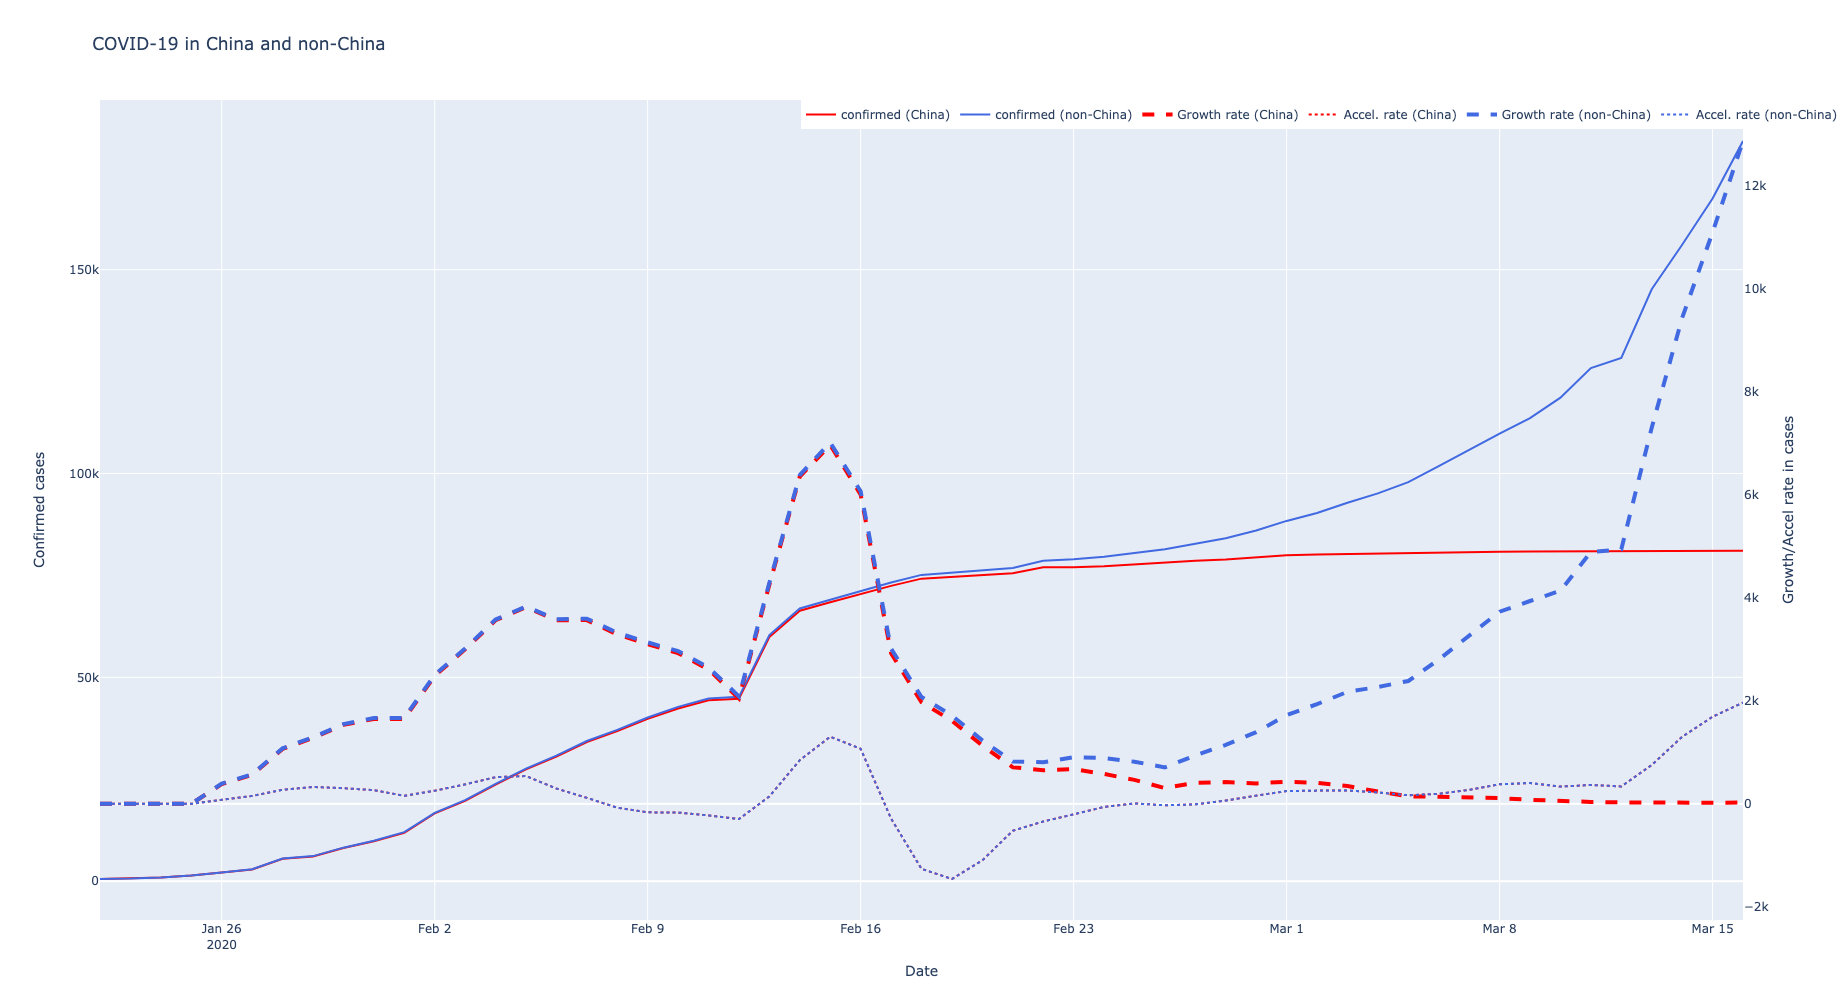

In [221]:
# Show fig
import plotly.express as px
import plotly.graph_objects as go

colorSequence = ["red", "royalblue"]

layout = go.Layout(title="COVID-19 in China and non-China", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

chinaColor = colorSequence[0]
nonChinaColor = colorSequence[1]
colorMap = {'confirmed (China)':chinaColor, 
           'growth_rate (China)':chinaColor, 
           'acceleration_rate (China)':chinaColor, 
           'confirmed (non-China)':nonChinaColor, 
           'growth_rate (non-China)':nonChinaColor,
           'acceleration_rate (non-China)':nonChinaColor,
          }

# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
traces_confirmed = px.line(pd.concat([df_china_prepared, df_non_china_prepared]).query('variable == ["confirmed (China)", "confirmed (non-China)"]'), 
                           x='date', 
                           y='value', 
                           color='variable',
                           color_discrete_map=colorMap,).data

# Reset index
df_non_china = df_non_china.reset_index()

# Add growth rate
trace_growth_china = go.Scatter(x=df_china['date'], 
                                y=df_china['growth_rate'], 
                                name='Growth rate (China)',
                                line=dict(color=chinaColor, 
                                          width=4, 
                                          dash='dash'), 
                                yaxis="y2")
trace_growth_non_china = go.Scatter(x=df_non_china['date'], 
                                    y=df_non_china['growth_rate'], 
                                    name='Growth rate (non-China)',
                                    line=dict(color=nonChinaColor, 
                                              width=4, 
                                              dash='dash'), 
                                    yaxis="y2")

# Add acceleration rate
trace_accel_china = go.Scatter(x=df_non_china['date'], 
                               y=df_non_china['acceleration_rate'], 
                               name='Accel. rate (China)',
                         line=dict(color=chinaColor, 
                                   width=2, 
                                   dash='dot'), 
                               yaxis="y2")

trace_accel_non_china = go.Scatter(x=df_non_china['date'], 
                                   y=df_non_china['acceleration_rate'], 
                                   name='Accel. rate (non-China)',
                         line=dict(color=nonChinaColor, 
                                   width=2, 
                                   dash='dot'), 
                                   yaxis="y2")

# Combine to make a tuple
traces_combined = traces_confirmed + (trace_growth_china, trace_accel_china, trace_growth_non_china, trace_accel_non_china,)
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()

In [265]:
#Get top ten countries by total cases
df_non_china = df_confirmed_grouped.query('countryregion != "China"')

top_countries_by_total_cases = df_non_china.groupby('countryregion').sum().nlargest(10, 'confirmed').reset_index()['countryregion']
df_non_china_top = df_confirmed_grouped[df_confirmed_grouped.reset_index()['countryregion'].isin(top_countries_by_total_cases)]

df_non_china_top.head()

,date,countryregion,confirmed,growth_rate,acceleration_rate
35,2020-01-22,Cruise Ship,0,0.0,0.0
48,2020-01-22,France,0,0.0,0.0
52,2020-01-22,Germany,0,0.0,0.0
68,2020-01-22,Iran,0,0.0,0.0
72,2020-01-22,Italy,0,0.0,0.0


In [266]:
# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
traces_confirmed = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='confirmed', 
                           color='countryregion').data

# Only plot 'growth'
traces_growth = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='growth_rate', 
                           color='countryregion').data

# Only plot 'acceleration'
traces_acceleration = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='acceleration_rate', 
                           color='countryregion').data

# traces_combined = traces_confirmed + traces_growth + traces_acceleration

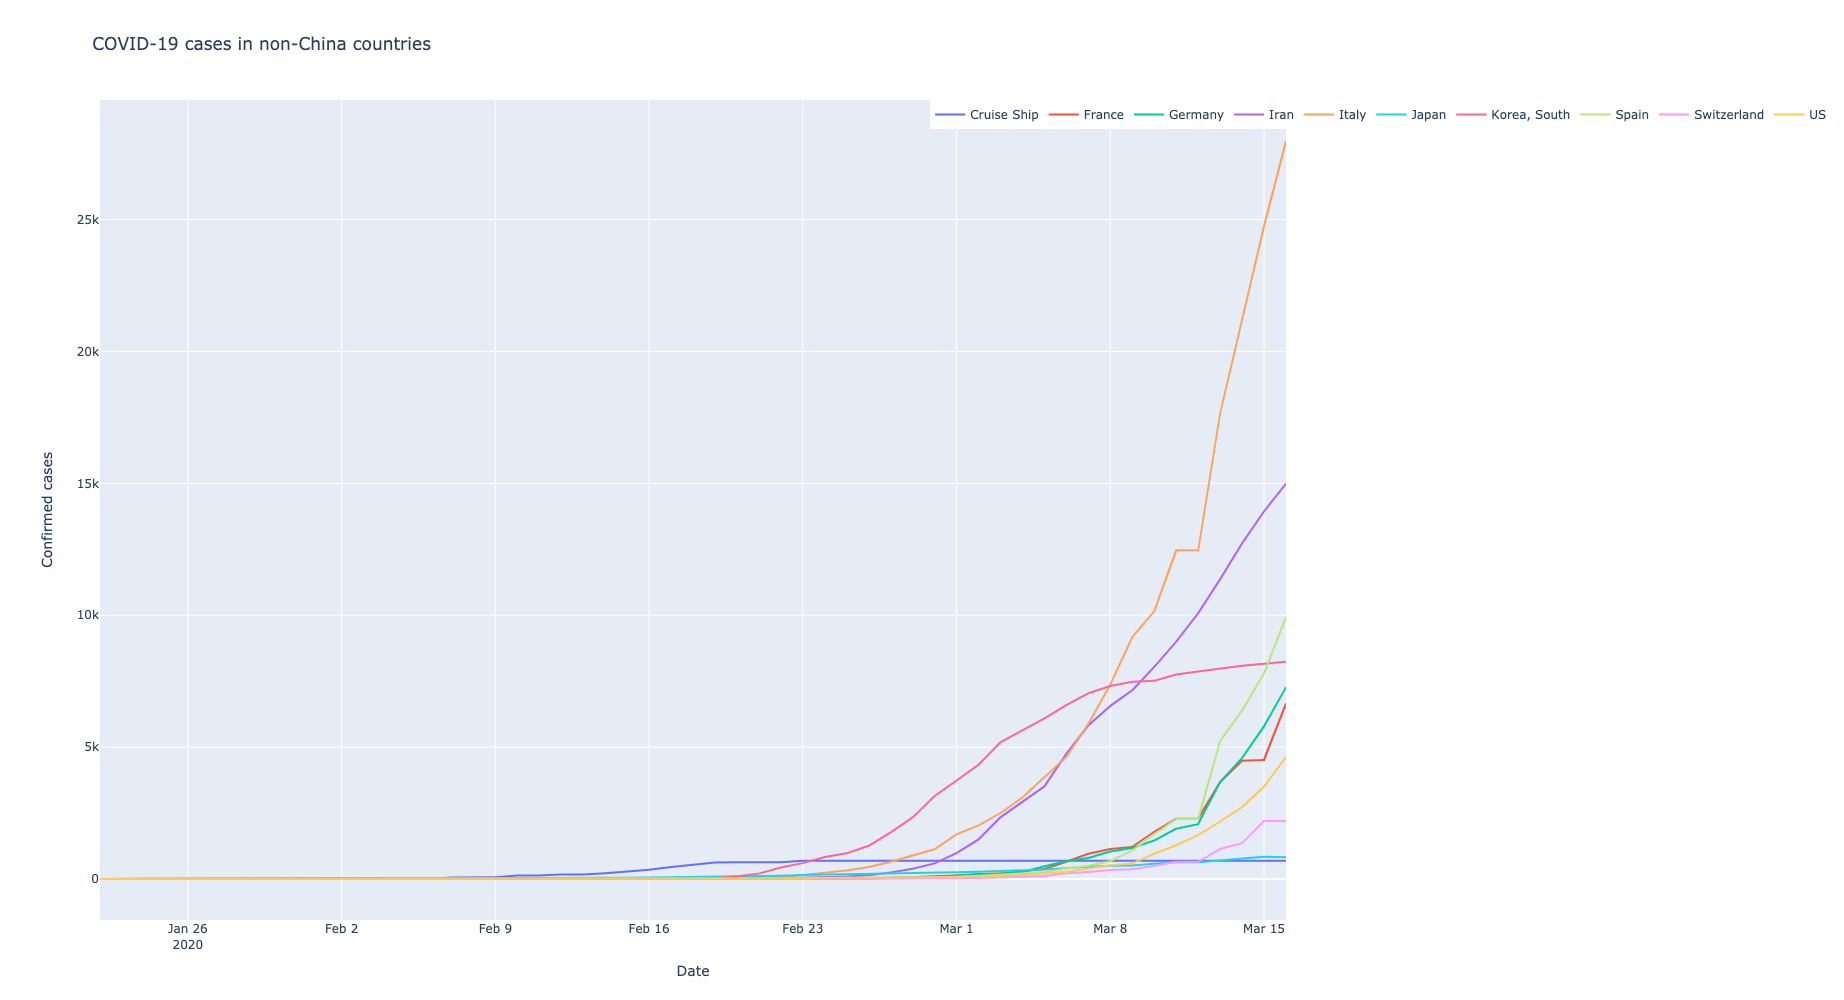

In [267]:
layout = go.Layout(title="COVID-19 cases in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_confirmed, layout=layout)
fig.show()

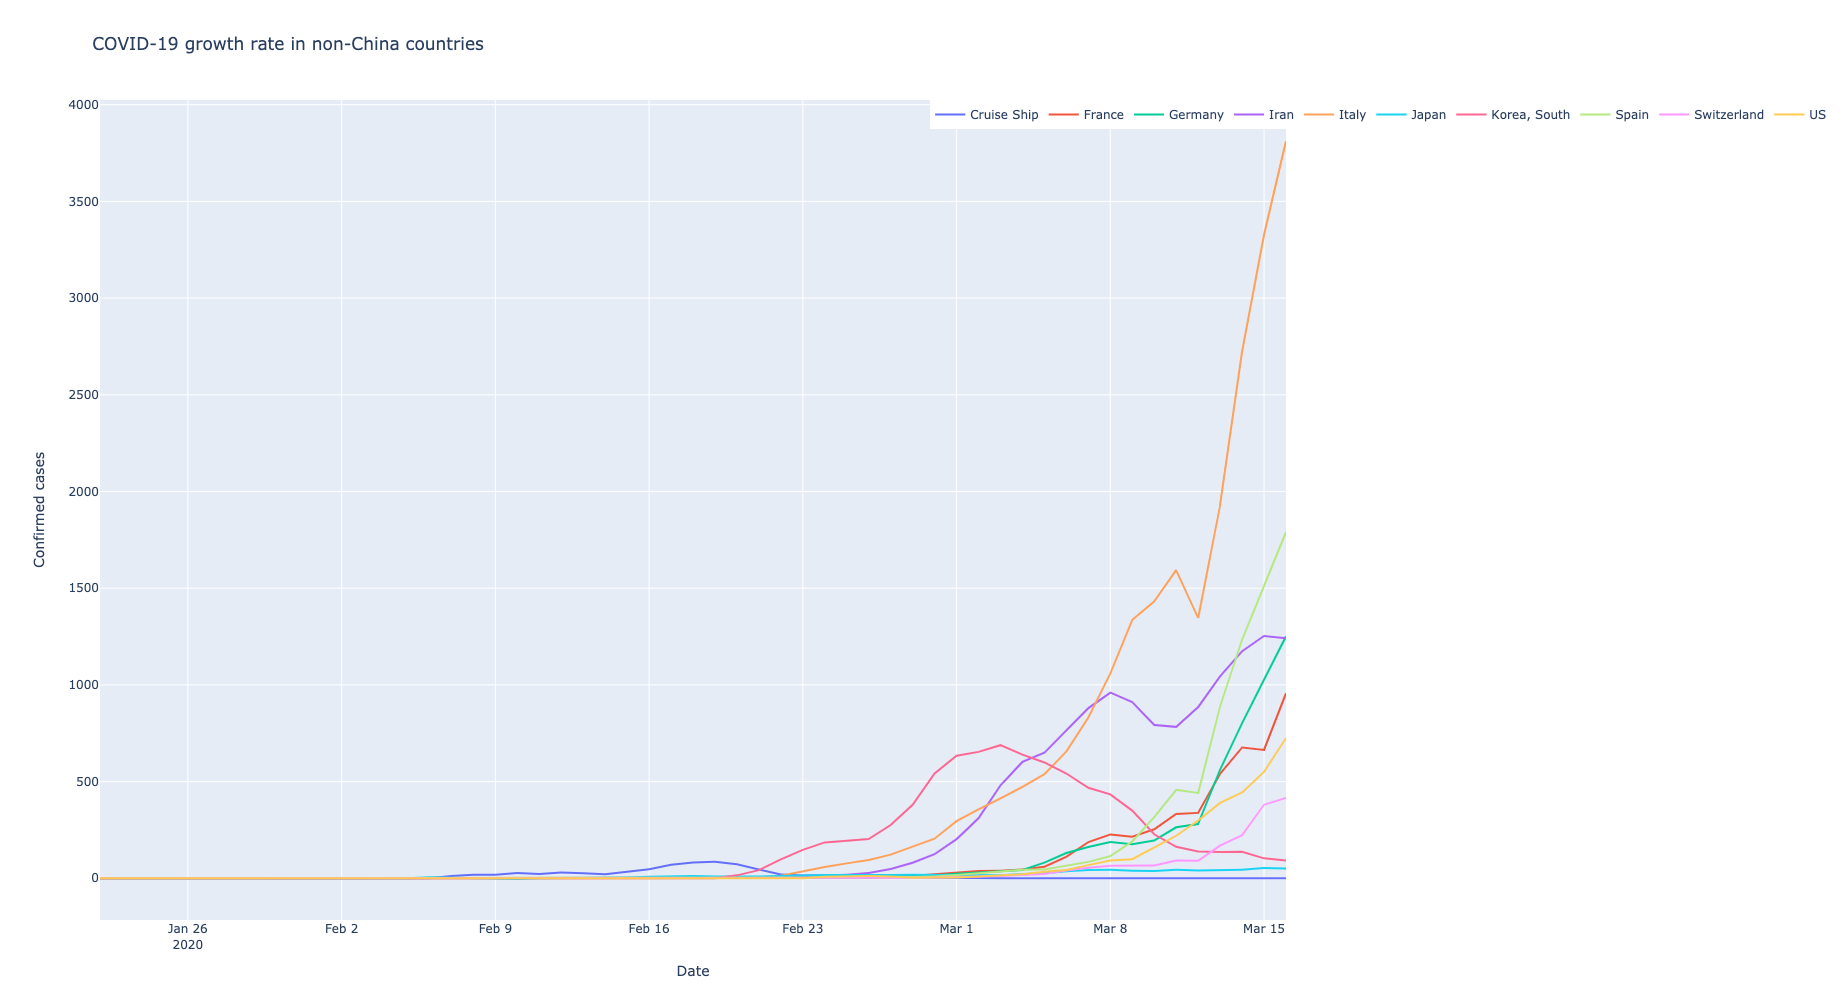

In [268]:
layout = go.Layout(title="COVID-19 growth rate in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_growth, layout=layout)
fig.show()

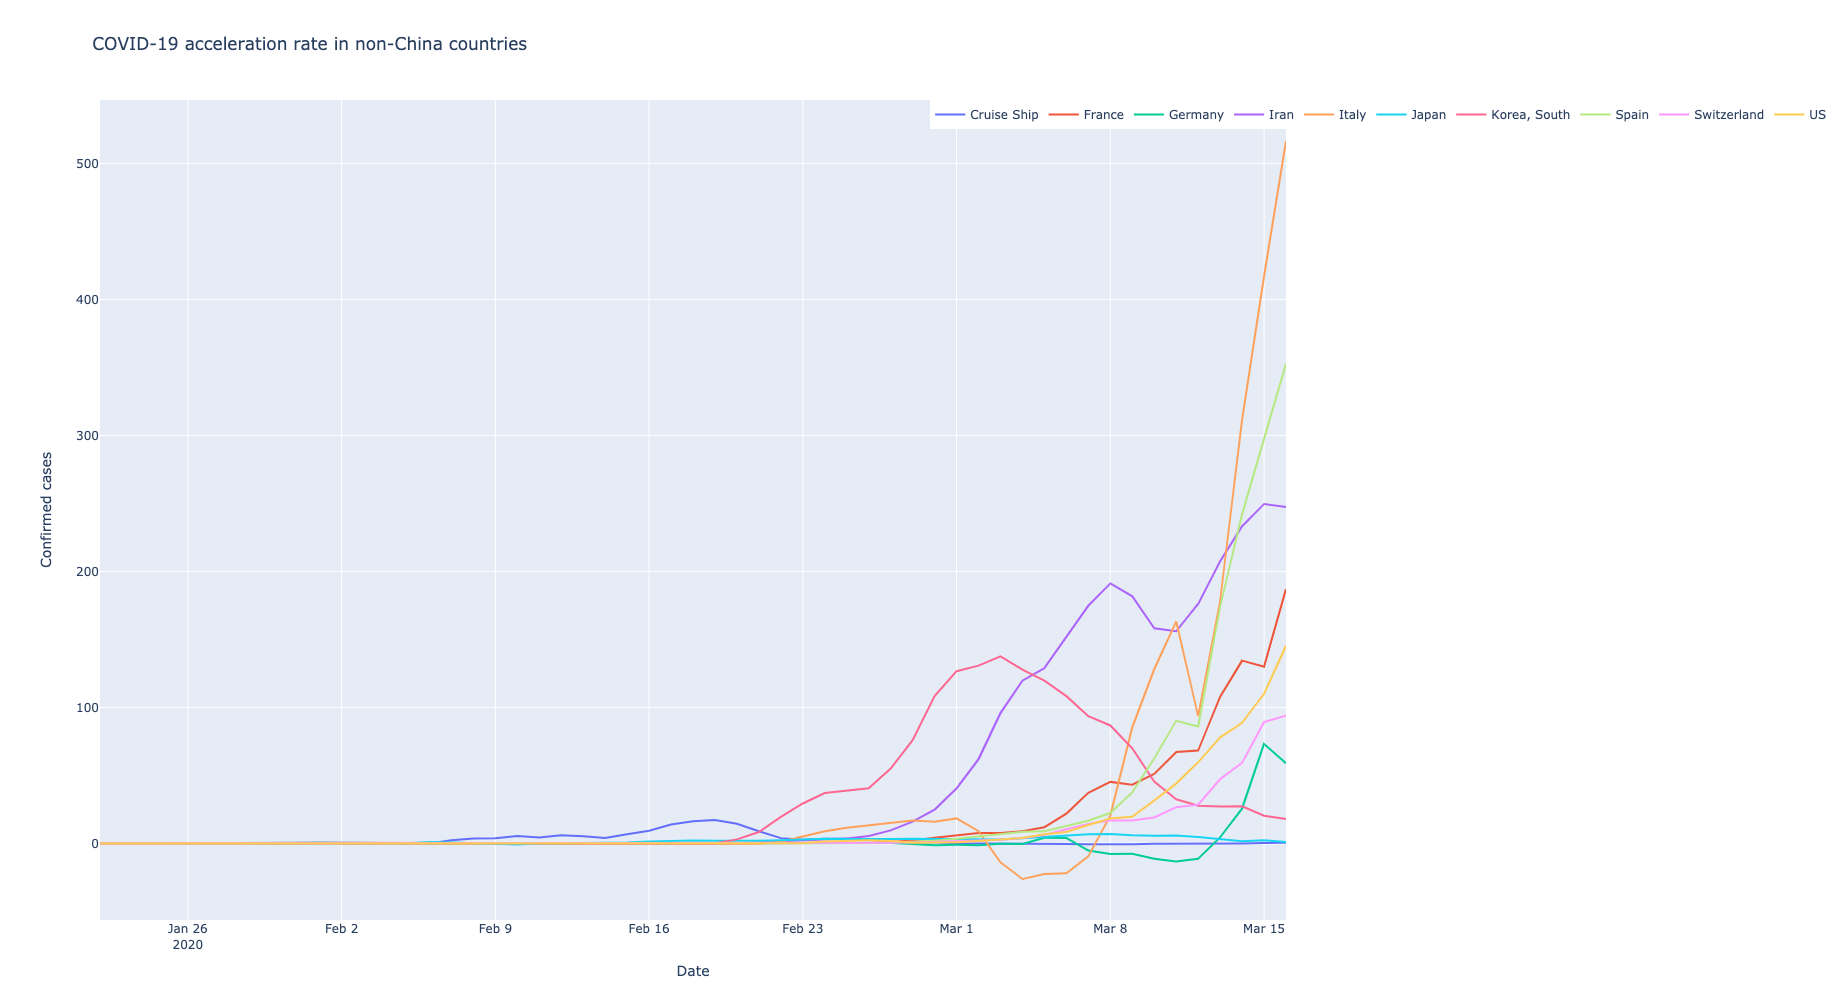

In [269]:
layout = go.Layout(title="COVID-19 acceleration rate in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_acceleration, layout=layout)
fig.show()